In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



In [3]:
from transforms import transforms
from Decon import SpectralDecon


### Define data

In [48]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


Load diffusion length data from Site A, in Ice Equivalents (I.E.) and in Water Equivalents (W.E.)

In [49]:
diffIE = pd.read_csv('/home/thea/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/SiteA_DepthDiffVas.txt','\t')
diffWE = pd.read_csv('/home/thea/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/SiteA_DepthDiff.txt','\t')

depIE = diffIE['Depth']; depIE_LT = depIE[(depIE > dTamb) & (depIE < dLaki)]
difIE = diffIE['sigma_o18']; difIE_LT = difIE[(depIE > dTamb) & (depIE < dLaki)]

depWE = diffWE['Depth']; depWE_LT = depWE[(depWE > dTamb) & (depIE < dLaki)]
difWE = diffWE['sigma_o18']; difWE_LT = difWE[(depWE > dTamb) & (depWE < dLaki)]


Plot the two different diffusion length profiles

In [50]:
#plt.plot(depIE,difIE)
#plt.plot(depIE_LT,difIE_LT)
#
#plt.plot(depWE,difWE)
#plt.plot(depWE_LT,difWE_LT)

### Compute diffusion length estimate of site 
### Determine diff len interval equating N = 32(/33)

In [60]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30)

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Sigma fit: 7.32
Min sigma analyt: 7.69
Starting sigma: 5.32 [cm]
Final sigma: 6.20 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


Calculate the firn diffusion length estimate by removing the sampling diffusion length from the estimate.

In [56]:
from DiffusionProfiles_calculations import sampling_sigma
sampleSize_ave = np.mean(np.diff(depth_LT))
print(f'Average sampling size in interval: {sampleSize_ave:.3f}\n')
sigma_sample = sampling_sigma(sampleSize_ave)
sigma_firn = np.sqrt(diffLen**2 - sigma_sample**2)

print(f'Total diffusion length estimate: \t{diffLen*100:.2f} [cm]')
print(f'Sampling diffusion length estimate: \t{sigma_sample*100:.2f} [cm]')
print(f'Firn diffusion length estimate: \t{sigma_firn*100:.2f} [cm]')


Average sampling size in interval: 0.039

Total diffusion length estimate: 	6.20 [cm]
Sampling diffusion length estimate: 	1.19 [cm]
Firn diffusion length estimate: 	6.08 [cm]


####  Find indices where N = 32. Find corresponding diffusion lengths

In [57]:
idx32 = np.where(np.asarray(arr_Npeaks) == N_InInt)[0]
idx32Cut = idx32[:-1]

diffLens32_tot = np.asarray(arr_DiffLens)[idx32Cut]
diffLens32_firn = np.sqrt(diffLens32_tot**2 - sigma_sample**2)

Plot the LT section, data and BD, along with firn diffusion length estimate.

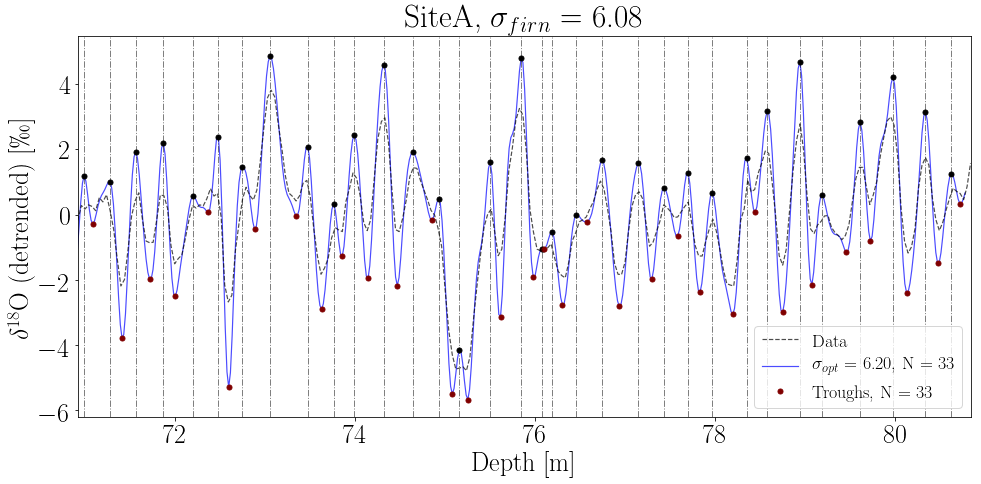

In [58]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)

troughs = sp.signal.find_peaks(-dataOpt)[0]
plt.plot(depthOpt[troughs],dataOpt[troughs], '.',color='maroon',ms=10, label=f'Troughs, N = {len(troughs)}')

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site+', $\sigma_{firn}$ = ' + f'{sigma_firn*100:.2f}',xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='k',zorder=1, s=25)

for i in range(len(peaks)):
    ax.axvline(depthOpt[peaks[i]],lw=1,color='k',ls='-.',alpha=0.5)
#for i in range(len(troughs)):
#    ax.axvline(depthOpt[troughs[i]],lw=1,color='maroon',ls='--', alpha=0.5)

#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')


## Estimate annual layer thickness and accumulation in W.E.

In [18]:
try:
    dens = data_dens['HLmodelOpti']
    depthDens = data_dens['depth']

    dens_LT = data_dens_LT['HLmodelOpti']
    depthDens_LT = data_dens_LT['depth']
except:
    dens = data_dens['HLmodel']
    depthDens = data_dens['depth']

    dens_LT = data_dens_LT['HLmodel']
    depthDens_LT = data_dens_LT['depth']
    
from scipy import interpolate

inter = sp.interpolate.interp1d(depthDens,dens)


densPeaks = inter(depthOpt[peaks])

densPeaks_intervals = np.asarray([(densPeaks[i]+densPeaks[i+1])/2 for i in range(len(densPeaks)-1)])

intervals = np.diff(depthOpt[peaks])
accumEsts = intervals*(densPeaks_intervals/1)
accum_ave = np.mean(accumEsts)
accum_std = np.std(accumEsts)

print(f'W.E. accumulation estimate from data: {accum_ave:.3f} +/- {accum_std:.3f} [m]')

W.E. accumulation estimate from data: 0.236 +/- 0.069 [m]


Plot density estimates at LT depth interval. Use this for computation from firn/ice depth to W.E. accumulation estimate.

[Text(0,0.5,'Depth'), Text(0.5,0,'Density')]

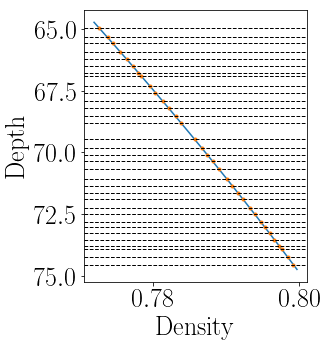

In [19]:
fig,ax = plt.subplots(figsize=(4,5))

ax.invert_yaxis()

ax.plot(dens_LT, depthDens_LT,'-')
ax.plot(densPeaks,depthOpt[peaks],'.')
for i in range(len(peaks)):
    ax.axhline(depthOpt[peaks[i]],lw=1,color='k',ls='--')
ax.set(xlabel='Density', ylabel='Depth')

In [20]:
densAve = np.mean(dens_LT)*1000
print(f'Average density in LT interval: \t{densAve}')

Average density in LT interval: 	786.3518591574838


### Determine temperature estimate interval (analytical solution) using modern day accumulation rate

In [21]:
# Modern day W.E. accumulation rate
accum = accum0 

# Create instance for temperature estimate solution
sigmaSolver_inst = sigma_Solver()

print(f'Accumulation estimate (W.E.): {accum:.3f}')
print(f'Accumulation estimate (I.E.): {accumIE:.3f}')
print(f'Modern temperature estimate: {Temp0}\n')

# Define what diffusion lengths to use - firn or total?
diffLens32 = diffLens32_firn # diffLens32_tot
T_intEst = np.zeros(len(diffLens32))

# Estimate temperatures given diffusion length estimates (equating N = 32)

for i in range(len(diffLens32)):
    T_est = sigmaSolver_inst.solveTemp(sigma_data = diffLens32[i], accum = accum, rho_CO = np.array([densAve]))# *(804.3/917.)
    T_intEst[i] = T_est
    if i%10 == 0:
        print(f'Computed temperature estimate: {T_est[0] - 273.15:.2f}')

Accumulation estimate (W.E.): 0.257
Accumulation estimate (I.E.): 0.280
Modern temperature estimate: -30.4

Computed temperature estimate: -37.36
Computed temperature estimate: -36.96


In [22]:
from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [23]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInt = np.asarray([33, 33, 33, 33, 33, 33])

T_est = []
diffLens_est = []
Tf_est = []
diffLens_est_f = []
for site, N in zip(sites,N_InInt):
    print(site+'\n')
    T, dL, Tf, dLf = TempEst_analytical(site, N)
    T_est.append(T)
    diffLens_est.append(dL)
    Tf_est.append(Tf)
    diffLens_est_f.append(dLf)


SiteA

Sigma fit: 7.32
Min sigma analyt: 7.69
Starting sigma: 5.32 [cm]
Final sigma: 6.20 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019
Average sampling size in interval: 0.0392 +/- 0.0006
SiteB

Sigma fit: 7.55
Min sigma analyt: 7.58
Starting sigma: 5.55 [cm]
Final sigma: 5.84 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019
Average sampling size in interval: 0.0389 +/- 0.0006
SiteD

Sigma fit: 7.83
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 4.55 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.019
Average sampling size in interval: 0.0377 +/- 0.0006
SiteE

Sigma fit: 7.76
Min sigma analyt: 8.85
Starting sigma: 5.76 [cm]
Final sigma: 6.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.021
Average sampling size in interval: 0.0425 +/- 0.0007
SiteG

Sigma fit: 7.94
Min sigma analyt: 8.85
Starting sigma: 5.94 [cm]
100. Npeaks: 30, diffLen: 6.944 cm
200. Npeaks: 32, diffLen: 7.949 cm
Final sigma: 8.63 [cm]
Final # of peaks: 33
Delta: 0.040
Delta

SiteA, 		N = 33
T0 = 		-29.41
T(sigma_max) = 	-36.14

SiteB, 		N = 33
T0 = 		-29.77
T(sigma_max) = 	-37.20

SiteD, 		N = 33
T0 = 		-28.3
T(sigma_max) = 	-43.03

SiteE, 		N = 33
T0 = 		-30.37
T(sigma_max) = 	-38.56

SiteG, 		N = 33
T0 = 		-30.1
T(sigma_max) = 	-28.77

Crete, 		N = 33
T0 = 		-30.4
T(sigma_max) = 	-36.96



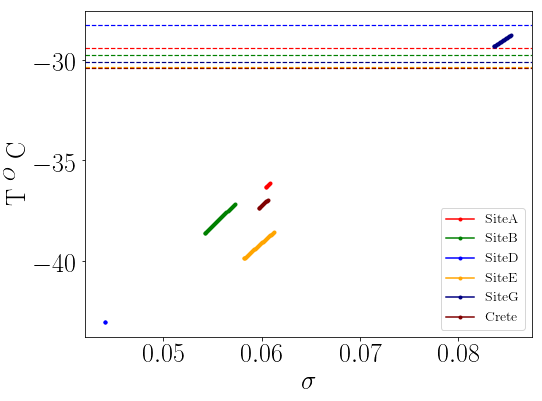

In [24]:
fig, ax = plt.subplots(figsize=(8,6))

Ts = [-29.41, -29.77, -28.30, -30.37, -30.10, -30.40]
colors = ['red','green','blue','orange','navy','maroon']
for i in range(len(Tf_est)):
    #ax.axhline(y=Ts[i])
    print(sites[i]+f', \t\tN = {N_InInt[i]}')
    print(f'T0 = \t\t{Ts[i]}')
    ax.axhline(y=Ts[i],color=colors[i], lw=1.2, ls='--')
    ax.plot(diffLens_est_f[i], Tf_est[i]-273.15, label=sites[i],marker='.', color=colors[i])
    print(f'T(sigma_max) = \t{max(Tf_est[i]-273.15):.2f}\n')
ax.set(xlabel='$\sigma$', ylabel='T $^O$ C')    
ax.legend(fontsize=14)

### Determine temperature estimate interval (analytical solution) using varying accumulation rate

In [25]:
sigmaFirn_max = np.zeros(len(diffLens_est_f))
dzs = [0.03919762845849803, 0.03885401459854004, 0.03774461538461542, 0.042455357142857135, 0.04102777777777775,0.026775401069518666]

for i in range(len(diffLens_est_f)):
    sigma_max = max(diffLens_est_f[i])
    sigma_sample = sampling_sigma(dzs[i])
    
    sigmaFirn_max[i] = np.sqrt(sigma_max**2 - sigma_sample**2)

In [19]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInt = [32, 33, 33, 32, 32, 32]
T0s = [-29.41, -29.77, -28.30, -30.37, -30.10, -30.40]
Accum0s = np.asarray([0.307, 0.327, 0.365, 0.225, 0.251,0.28])*(917/1000)
diffLen_maxs = sigmaFirn_max#[0.0614, 0.0585, 0.0456, 0.0595, 0.0846, 0.0602]
#diffLen_teos = [0.0652, 0.0643, 0.0625,0.0750,0.0766,0.0728]

j = 4
site = sites[j]
N = N_InInt[j]
T0 = T0s[j]
Accum0 = Accum0s[j]
diffLen_max = diffLen_maxs[j]

accum_arr = np.arange(0.05,1,0.01)


In [20]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = np.asarray(data_d18O_LT['depth'])
d18O_LT = np.asarray(data_d18O_LT['d18O'])


In [21]:
diff = data_diff['sigma_o18']
dep = data_diff['Depth']

diff_LT = data_diff_LT['sigma_o18']
dep_LT = data_diff_LT['Depth']


try:
    dens = data_dens['HLmodelOpti']
    depdens = data_dens['depth']

    dens_LT = data_dens_LT['HLmodelOpti']
    depdens_LT = data_dens_LT['depth']

except:
    dens = data_dens['HLmodel']
    depdens = data_dens['depth']

    dens_LT = data_dens_LT['HLmodel']
    depdens_LT = data_dens_LT['depth']
    
dens_ave = np.mean(dens_LT)*1000
print(dens_ave)

790.1114504998296


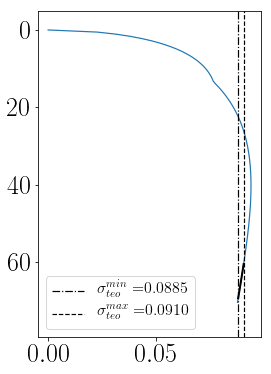

In [22]:
fig,ax = plt.subplots(figsize = (4,6))
ax.invert_yaxis()
plt.plot(np.asarray(diff),np.asarray(dep), lw=1.2)
plt.plot(np.asarray(diff_LT),np.asarray(dep_LT), color='k', lw=2)
plt.axvline(min(diff_LT),ls='-.',color='k',lw=1.2,label='$\sigma_{teo}^{min} = $'+f'{min(diff_LT):.4f}')
plt.axvline(max(diff_LT),ls='--',color='k',lw=1.2,label='$\sigma_{teo}^{max} = $'+f'{max(diff_LT):.4f}')

ax.legend(fontsize=16);
ax.set(ylim=(max(dep_LT)+10,-5))
diffLen_teoMin = min(diff_LT)
diffLen_teoMax = max(diff_LT)


In [23]:
from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [24]:
T_est = np.zeros(len(accum_arr))
T_teoMin_est = np.zeros(len(accum_arr))
T_teoMax_est = np.zeros(len(accum_arr))

dens_aves = dens_ave*np.ones_like(accum_arr)
i = 0
for accum in accum_arr:
    T = TempEst_analytical_arr(np.array([diffLen_max]),accum)
    T_teoMin = TempEst_analytical_arr(np.array([diffLen_teoMin]),accum, rhoMeans_in=dens_aves)
    T_teoMax = TempEst_analytical_arr(np.array([diffLen_teoMax]),accum)
    T_est[i] = T[-1]
    T_teoMin_est[i] = T_teoMin[-1]
    T_teoMax_est[i] = T_teoMax[-1]
    i += 1

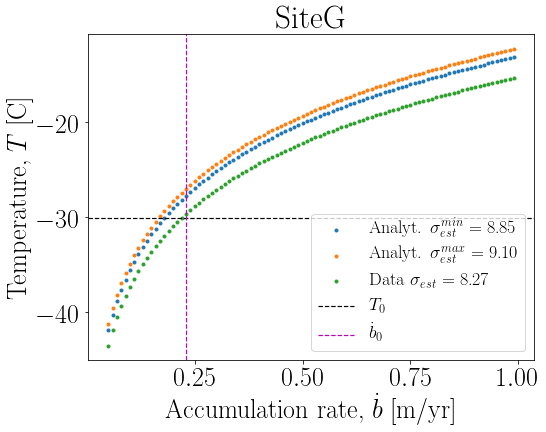

In [25]:
fig, ax = plt.subplots(figsize=(8,6))


ax.plot(accum_arr,T_teoMin_est-273.15,'.',label='Analyt. $\sigma_{est}^{min}$' + f' = {diffLen_teoMin*100:.2F}')
ax.plot(accum_arr,T_teoMax_est-273.15,'.',label='Analyt. $\sigma_{est}^{max}$' + f' = {diffLen_teoMax*100:.2F}')
ax.plot(accum_arr,T_est-273.15,'.',label='Data $\sigma_{est}$' + f' = {diffLen_max*100:.2F}')
ax.axhline(y=T0,ls='--',color='k', lw=1.2, label='$T_0$')
ax.axvline(x=Accum0,ls='--',color='m', lw=1.2, label='$\dot{b}_0$')
ax.set(xlabel='Accumulation rate, $\dot{b}$ [m/yr]', ylabel='Temperature, $T$ [C]', title=site)
ax.legend(fontsize=18)